In [112]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(15,5)
import pandas as pd

In [8]:
data_file = 'XwindowsDocData.mat'
load_data = sio.loadmat(data_file)
X_train=load_data['xtrain']
print(type(X_train),X_train.shape)
y_train=load_data['ytrain']
print(type(y_train),y_train.shape)

<class 'scipy.sparse.csc.csc_matrix'> (900, 600)
<class 'numpy.ndarray'> (900, 1)


In [16]:
# 获取总共有多少个类
C = np.unique(y_train)

In [83]:
pseudoCount = 1  # 伪计数为1
N_train,D = X_train.shape
# 初始化参数矩阵theta和类先验概率
theta = np.empty((len(C),D))
c_prior = np.empty(len(C))
# 对X_train进行统计
for c in C:
    XX = X_train[y_train.flatten()==c]   # 获取属于c的所有样本
    Non = np.sum(XX,0)           # 统计每个特征为1的数量
    Noff = XX.shape[0]-Non
    theta[c-1,:]=(Non+pseudoCount)/(Non+Noff+2*pseudoCount)
    c_prior[c-1]= XX.shape[0]/N_train
    # print(Non.shape,Noff.shape)
    # print(Non.shape)
    # print(XX.shape)
    # print(c_pro)
    print(theta)
    print(c_prior)


[[0.00442478 0.00221239 0.00663717 ... 0.00221239 0.00442478 0.02433628]
 [1.31028224 1.31028224 1.31028224 ... 1.31207097 1.31207097 1.30549658]]
[0.5        1.16884762]
[[0.00442478 0.00221239 0.00663717 ... 0.00221239 0.00442478 0.02433628]
 [0.01106195 0.01106195 0.01106195 ... 0.00442478 0.00442478 0.02876106]]
[0.5 0.5]


Text(0.5,1,'p(xj=1|y=2)')

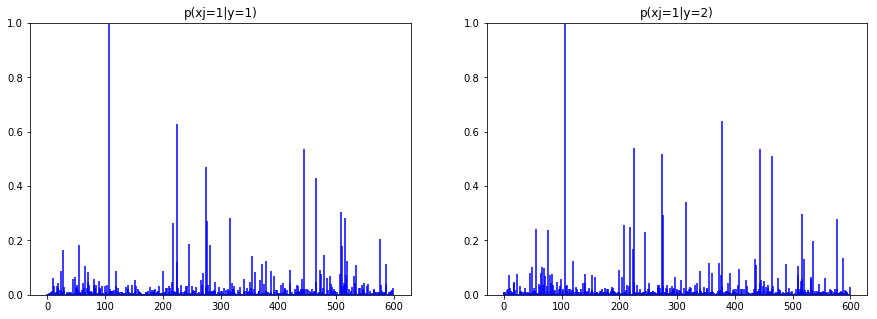

In [141]:
ax1 = plt.subplot(121)
ax1.vlines(np.arange(theta.shape[-1]),0,theta[0,:],colors='blue')
ax1.set_ylim(0,1)
ax1.set_title('p(xj=1|y=1)')
ax2 = plt.subplot(122)
ax2.vlines(np.arange(theta.shape[-1]),0,theta[1,:],colors='blue')
ax2.set_ylim(0,1)
ax2.set_title('p(xj=1|y=2)')

In [56]:
X_test = load_data['xtest'].toarray()
print(X_test.shape)
y_test = load_data['ytest']

(900, 600)


In [81]:
Ntest = X_test.shape[0]
logPrior = np.log(c_prior)
logPost = np.empty((len(C),Ntest))
logTrue = np.log(theta)
logTrueNot = np.log(1-theta)
XtestNot = 1-X_test
XtrainNot = 1-X_train.toarray()
print(logTrue.shape)

(2, 600)


In [82]:
for c in C:
    L_true = np.dot(logTrue[c-1,:],X_test.T)
    print(L_true.shape)
    L_false = np.dot(logTrueNot[c-1,:],XtestNot.T)
    print(L_false.shape)
    logPost[c-1,:]=L_true+L_false+logPrior[c-1]
print(logPost)
y_hat = np.argmax(logPost,0)+1
1-y_hat[y_hat==y_test.flatten()].size/y_hat.size

(900,)
(900,)
(900,)
(900,)
[[-41.18813634 -23.01671991 -71.89830658 ... -43.85026596 -26.02082748
  -39.14087707]
 [-46.14089735 -27.50579873 -79.7469371  ... -38.79526696 -22.47443335
  -40.55321972]]


0.18666666666666665

In [88]:
# 求取MI
theta_j = np.dot(c_prior[np.newaxis,:],theta)
I=np.empty((len(C),D))
for c in C:
    I[c-1,:]=theta[c-1,:]*c_prior[c-1]*np.log(theta[c-1,:]/theta_j)+ \
    (1-theta[c-1,:])*c_prior[c-1]*np.log((1-theta[c-1,:])/(1-theta_j))
MI = np.sum(I,0)
print(MI.shape)

(600,)


In [95]:
vocab = load_data['vocab']
type(vocab)

numpy.ndarray

In [139]:
cols=['class1','prob','class2','prob','highest MI','MI']
first_col = [element[0] for element in vocab[np.argsort(-theta[0,:])[0:5]].flatten()]
second_col = -np.sort(-theta[0,:])[0:5]
third_col = [element[0] for element in vocab[np.argsort(-theta[1,:])[0:5]].flatten()]
forth_col = -np.sort(-theta[1,:])[0:5]
fivth_col = [element[0] for element in vocab[np.argsort(-MI)[0:5]].flatten()]
sixth_col = -np.sort(-MI)[0:5]
df = pd.DataFrame({'class1':first_col,'prob':second_col,'class2':third_col,'prob':forth_col,
                   'highest MI':fivth_col,'MI':sixth_col}
)
df.loc[:,cols]

,class1,prob,class2,prob,highest MI,MI
0,subject,0.997788,subject,0.997788,windows,0.149046
1,this,0.639381,windows,0.639381,microsoft,0.066171
2,with,0.539823,this,0.539823,dos,0.063858
3,but,0.537611,with,0.537611,motif,0.054201
4,you,0.517699,but,0.517699,window,0.046677
